## Restricted Boltzmann Machine

In [22]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import netket as nk
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import flax.linen as nn
import netket.nn as nknn

In [23]:
L = 6   
J1 = 1.0
J2 = 0.5

lattice = nk.graph.Square(length=L, max_neighbor_order=2, pbc=True)
print("Number of sites:", lattice.n_nodes)

Number of sites: 36


In [24]:
from collections import Counter

# Sequence of color indices, same order as lattice.edges()
edge_colors = lattice.edge_colors

print("Unique edge colors:", set(edge_colors))
print("Edges per type:", Counter(edge_colors))
print(edge_colors)

Unique edge colors: {0, 1}
Edges per type: Counter({0: 72, 1: 72})
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [25]:
edges = lattice.edges()  # returns (i, j) only
for (idx, (i, j)) in enumerate(edges[:10]):  # first 10 edges
    print(f"edge {idx}: ({i}, {j}), color = {edge_colors[idx]}")

edge 0: (24, 30), color = 0
edge 1: (0, 30), color = 0
edge 2: (6, 12), color = 0
edge 3: (15, 21), color = 0
edge 4: (1, 31), color = 0
edge 5: (3, 4), color = 0
edge 6: (18, 23), color = 0
edge 7: (26, 27), color = 0
edge 8: (16, 17), color = 0
edge 9: (12, 13), color = 0


In [26]:
hilbert_space = nk.hilbert.Spin(s=0.5, total_sz=0.0, N=lattice.n_nodes)

In [27]:
hamiltonian = nk.operator.Heisenberg(
    hilbert=hilbert_space,
    graph=lattice,
    J=[J1, J2],
    sign_rule=[False, False],  
)

print("Number of terms in H:", hamiltonian.n_operators)

Number of terms in H: 144


In [28]:

rbm_model = nk.models.RBM(
    alpha=2,          # hidden-to-visible ratio
    use_hidden_bias=True,
    use_visible_bias=True,
)

In [29]:
sampler = nk.sampler.MetropolisExchange(
    hilbert=hilbert_space,
    graph=lattice,
    d_max=2,
)

In [30]:
vstate_rbm = nk.vqs.MCState(
    sampler=sampler,
    model=rbm_model,
    n_samples=1024,
    n_discard_per_chain=10,
)

In [31]:
print("Number of RBM parameters:", vstate_rbm.n_parameters)

Number of RBM parameters: 2700


In [32]:
opt_rbm = nk.optimizer.Adam(learning_rate=0.01)

gs_rbm = nk.driver.VMC_SR(
    hamiltonian=hamiltonian,
    optimizer=opt_rbm,
    diag_shift=0.01,
    variational_state=vstate_rbm,
)

print("RBM number of parameters:", vstate_rbm.n_parameters)

Automatic SR implementation choice:  NTK
RBM number of parameters: 2700


In [33]:
log = nk.logging.RuntimeLog()

In [34]:
gs_rbm.run(n_iter=300, out=log)

100%|██████████| 300/300 [05:10<00:00,  1.03s/it, Energy=-17.994796 ± 0.000082 [σ²=3.5e-06, R̂=1.409]]


(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [35]:
import numpy as np

data   = log.data              # HistoryDict
E_hist = data["Energy"]        # History with keys ['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr']

print(E_hist)                  # optional: to inspect
# History(keys=['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], n_iters=...)

# Arrays:
iters      = E_hist.iters                  # shape (n_iter,)
energy     = E_hist.Mean.real              # shape (n_iter,)
energy_err = E_hist.Sigma.real             # shape (n_iter,) – this is the standard error of the mean

# Last point:
last_E      = energy[-1]
last_E_err  = energy_err[-1]

print(f"Final energy ≈ {last_E:.6f} ± {last_E_err:.6f}")



History(keys=['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], n_iters=300)
Final energy ≈ -17.994796 ± 0.000082


In [36]:
E_per_site     = last_E / lattice.n_nodes
E_per_site_err = last_E_err / lattice.n_nodes

print(f"Final energy per site ≈ {E_per_site:.6f} ± {E_per_site_err:.6f}")


Final energy per site ≈ -0.499855 ± 0.000002


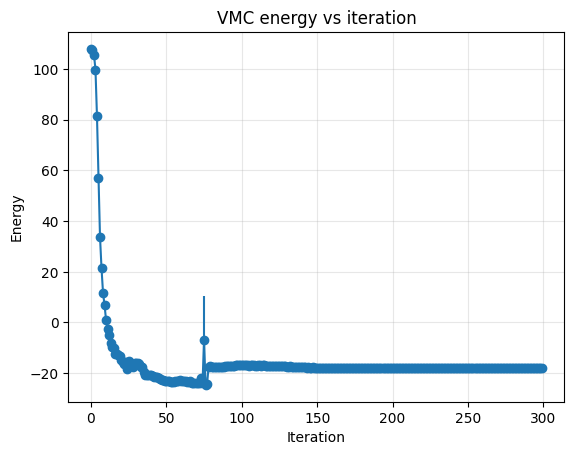

In [37]:
import matplotlib.pyplot as plt

iters      = E_hist.iters
energy     = E_hist.Mean.real
energy_err = E_hist.Sigma.real

plt.errorbar(
    iters,
    energy,
    yerr=energy_err,
    fmt="o-",
)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VMC energy vs iteration")
plt.grid(True, alpha=0.3)
plt.show()
